In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler
#import torchvision
#import lightning


In [2]:
# data_dir = os.path.join(os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/data_batch_1")
data_dir = os.path.join(
    os.path.dirname(os.getcwd()),
    "Data/CIFAR10/cifar-10-batches-py",
    "train_data.pkl",
)
data_dir_val = os.path.join(
    os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/test_batch"
)
# batch_size = 2
num_in_channels = 3
dim_z = 64
kern_size = 4
lr = 2e-4
num_epochs = 3

num_disc_feat = 128
disc_stride = 1
disc_padding_size = 0

num_gen_feat = 128
gen_stride = 3
gen_padding_size = 1

mean = 0.0
std = 0.02  # from the DCGAN paper

if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"


In [3]:
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [102]:
def process_data(folder_dir):
    file_paths = os.listdir(folder_dir)
    combined_img_data = []
    combined_label_data = []
    for file in file_paths:
        if "data_batch" in file:
            combined_img_data.append(
                unpickle(os.path.join(folder_dir, file))[b"data"]
            )
            combined_label_data.append(
                unpickle(os.path.join(folder_dir, file))[b"labels"]
            )
    combined_img_data = np.concatenate(combined_img_data)
    combined_label_data = np.concatenate(combined_label_data)
    # with open(os.path.join(folder_dir, "train_img_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_img_data, f)
    # with open(os.path.join(folder_dir, "train_label_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_label_data, f)

    train_data = {}
    train_data[b"data"] = combined_img_data
    train_data[b"labels"] = combined_label_data
    with open(os.path.join(folder_dir, "train_data.pkl"), "wb") as f:
        pickle.dump(train_data, f)

In [ ]:
process_data(
    os.path.join(
        os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py"
    )
)

In [74]:
(unpickle(data_dir).keys())


dict_keys([b'data', b'labels'])

In [18]:
def normalize_image(image):
    image = image / 255.0
    image = (image - 0.5) * 2.0
    return image

In [19]:
class TrainDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.train_data = unpickle(data_dir)

    def __getitem__(self, idx):
        de_norm_img = self.train_data[b"data"][idx].reshape(3, 32, 32).transpose(1, 2, 0)
        img = torch.tensor(
            normalize_image(de_norm_img),
            dtype=torch.float32,
        )
        # img = torch.nn.functional.normalize(img)
        label = torch.tensor(
            self.train_data[b"labels"][idx], dtype=torch.float32
        )
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.train_data[b"labels"])

In [20]:
class ValDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.val_data = unpickle(data_dir)

    def __getitem__(self, idx):
        de_norm_img = self.val_data[b"data"][idx].reshape(3, 32, 32).transpose(1, 2, 0)
        img = torch.tensor(
            normalize_image(de_norm_img), dtype=torch.float32
        )
        # img = torch.nn.functional.normalize(img)
        label = torch.tensor(self.val_data[b"labels"][idx], dtype=torch.float32)
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.val_data[b"labels"])

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            # nn.BatchNorm2d(num_in_channels),
            nn.Conv2d(
                num_in_channels,
                num_disc_feat,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat,
                num_disc_feat * 2,
                kern_size,
                4,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 2),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 2,
                num_disc_feat * 4,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 4),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 4,
                1,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(1),
            nn.LeakyReLU()
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                dim_z, num_gen_feat * 4, kern_size, 1, 0, bias=False
            ),
            # ConvTranspose2d are the fractionally strided convolutions used for upscaling mentioned in the paper
            nn.BatchNorm2d(num_gen_feat * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 4, num_gen_feat * 2, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 2, num_gen_feat, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat, num_in_channels, kern_size, 2, 1, bias=False
            ),
            nn.Tanh(),
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.ConvTranspose2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [201]:
train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0, shuffle=True)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)

val_dataset = ValDataset(data_dir_val)
val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0, shuffle=True)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=val_sampler,
)

In [9]:
def denormalize_images(images):
    # Reverse normalization
    denormalized_images = (images + 1) / 2.0
    denormalized_images = (denormalized_images * 255).astype(np.uint8)
    return denormalized_images


In [10]:
def train(num_epochs, data_dir, data_dir_val, device, train=True, **kwargs):

    loss_fn = torch.nn.BCEWithLogitsLoss()

    batch_size = kwargs.get("batch_size", 100)
    gen_lr = kwargs.get("gen_lr", 2e-4)
    disc_lr = kwargs.get("disc_lr", 2e-4)
    k = kwargs.get("k", 1)
    
    train_dataset = TrainDataset(data_dir)
    train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0, shuffle=True)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=train_sampler,
    )
    if train == False:
        val_dataset = ValDataset(data_dir_val)
        val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0, shuffle=True)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            sampler=val_sampler,
        )
    
    optimG = torch.optim.AdamW(gen.parameters(), lr=gen_lr, betas=(0.5, 0.9), weight_decay=0.2)
    optimD = torch.optim.AdamW(disc.parameters(), lr=disc_lr, betas=(0.5, 0.9), weight_decay=0.1)
    # optimD = torch.optim.SGD(disc.parameters(), lr=2e-4)

    # noise = torch.randn(28, dim_z, 1, 1, device=device)

    # real_label = 1
    # fake_label = 0
    loss_d, loss_g, imgs = [], [], []
    
    if train:
        for i in range(num_epochs):
            print(f"Epoch no. :  {i+1}")
            nan_flag = False
            if nan_flag==False:
                
                for _ in range(k):
                    if nan_flag==False:
                        for j, mini_batch in enumerate(train_loader):

                            optimD.zero_grad()

                            # train disc first
                            x_real = mini_batch["img"].to(device)
                            x_real = x_real.reshape(batch_size, num_in_channels, 32, 32)
                            labels = torch.full(
                                (batch_size,), 1.0, dtype=torch.float32, device=device
                            )
                            # out_disc_r = disc(x_real).flatten().sigmoid()
                            out_disc_r = disc(x_real).flatten()

                            # print(out_disc_r)
                            loss_disc_r = loss_fn(out_disc_r, labels)
                            loss_disc_r.backward()

                            x_fake = gen(torch.rand(batch_size, dim_z, 1, 1, device=device))
                            labels = torch.full(
                                (batch_size,), 0.0, dtype=torch.float32, device=device
                            )
                            # out_disc_f = disc(x_fake).flatten().sigmoid()
                            out_disc_f = disc(x_fake).flatten()
                            loss_disc_f = loss_fn(out_disc_f, labels)
                            if torch.isnan(loss_disc_f) or torch.isnan(loss_disc_r):
                                nan_flag = True
                                break

                            loss_disc_f.backward()

                            loss_disc = (
                                loss_disc_f.mean().item() + loss_disc_r.mean().item()
                            ) / 2.0

                            loss_d.append(loss_disc)

                            if j % 1000 == 0:
                                print(f"Discriminator loss after {j} steps = {loss_d[j + _*train_dataset.__len__()//batch_size + i*train_dataset.__len__()//batch_size]}")

                            optimD.step()
                    
                for j, mini_batch in enumerate(train_loader):

                    # train gen
                    optimG.zero_grad()

                    x_gen = gen(torch.rand(batch_size, dim_z, 1, 1, device=device))
                    x_gen = torch.nn.functional.normalize(x_gen)
                    # out = disc(x_gen).flatten().sigmoid()
                    out = disc(x_gen).flatten()
                    labels = torch.full(
                        (batch_size,), 1.0, dtype=torch.float32, device=device
                    )
                    loss_gen = loss_fn(out, labels)
                    loss_gen.backward()

                    loss_g.append(loss_gen.item())

                    if loss_disc == np.NaN or loss_gen.item() == np.NaN:
                        nan_flag = True
                        break

                    optimG.step()

                    if j % 1000 == 0:
                        print(f"Generator loss after {j} steps = {loss_g[j + i*train_dataset.__len__()//batch_size]}")

                with torch.no_grad():
                    gen_img = gen(torch.rand(2, dim_z, 1, 1, device=device))
                    gen_img = denormalize_images(gen_img[0].cpu().detach().numpy().transpose(1, 2, 0))
                    imgs.append(gen_img)
                    plt.imshow(gen_img)
                    plt.show()
                    plt.imshow(mini_batch['img'][0].cpu().numpy())
                    plt.show()
                
    return loss_d, loss_g, imgs

In [11]:
disc = Discriminator().to(device)
gen = Generator().to(device)
loss_disc, loss_gen, images = [], [], []


In [ ]:
g_lr = 2e-4
for g_lr in np.arange(9e-5, 4e-4, 2e-5):
    for d_lr in np.arange(4e-5, 2e-4, 2e-5):
        for k in np.arange(2,5, 1):
            disc = Discriminator().to(device)
            gen = Generator().to(device)
            l_disc, l_gen, img = train(num_epochs=10, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=50, disc_lr=d_lr, gen_lr=g_lr, k=k)
            loss_disc.append(l_disc)
            loss_gen.append(l_gen)
            images.append(img)

Epoch no. :  1
Discriminator loss after 0 steps = 0.47884470224380493
Discriminator loss after 0 steps = 0.4703804850578308
Generator loss after 0 steps = 0.39215126633644104


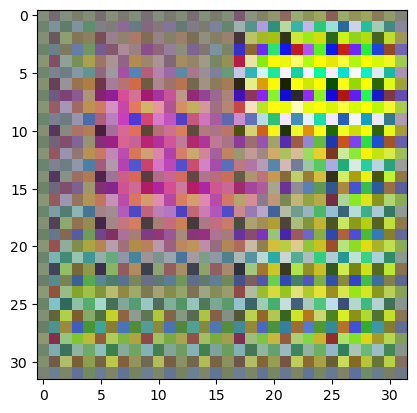

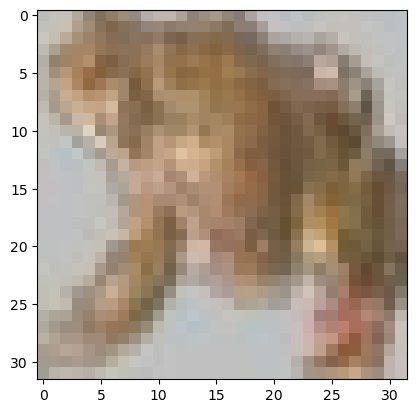

Epoch no. :  2
Discriminator loss after 0 steps = 0.4703804850578308
Discriminator loss after 0 steps = 0.46729791909456253
Generator loss after 0 steps = 0.31762802600860596


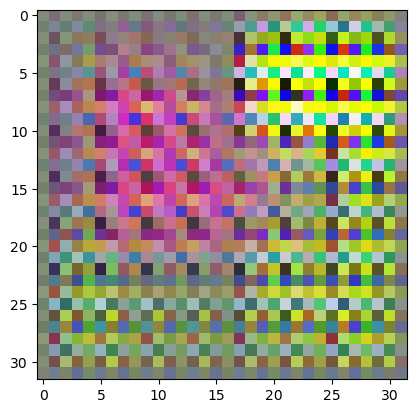

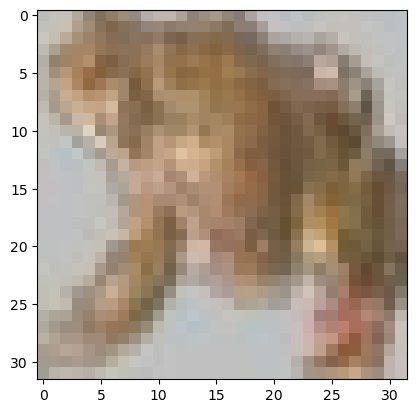

Epoch no. :  3
Discriminator loss after 0 steps = 0.46729791909456253
Discriminator loss after 0 steps = 0.4655628949403763
Generator loss after 0 steps = 0.3118939995765686


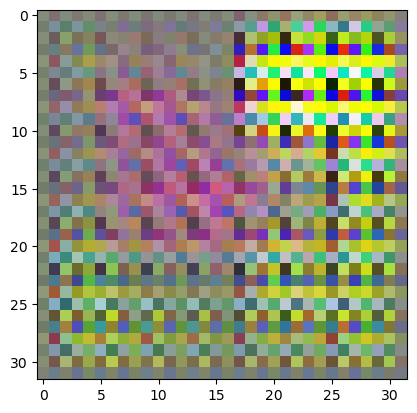

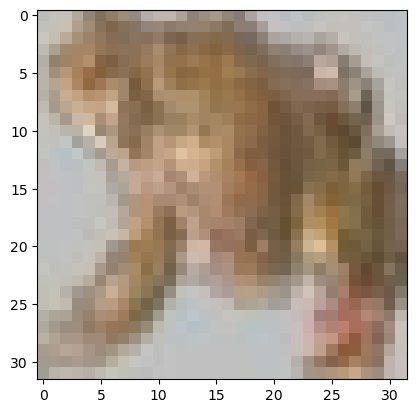

Epoch no. :  4
Discriminator loss after 0 steps = 0.4655628949403763
Discriminator loss after 0 steps = 0.46431004256010056
Generator loss after 0 steps = 0.3315381407737732


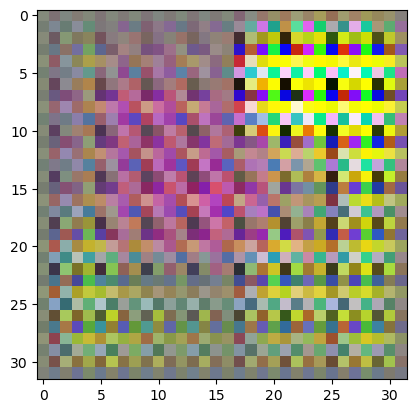

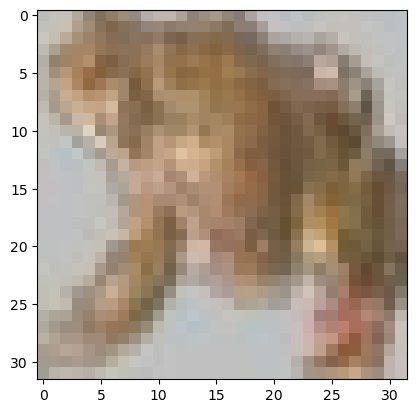

Epoch no. :  5
Discriminator loss after 0 steps = 0.46431004256010056
Discriminator loss after 0 steps = 0.46446458250284195
Generator loss after 0 steps = 0.2667272984981537


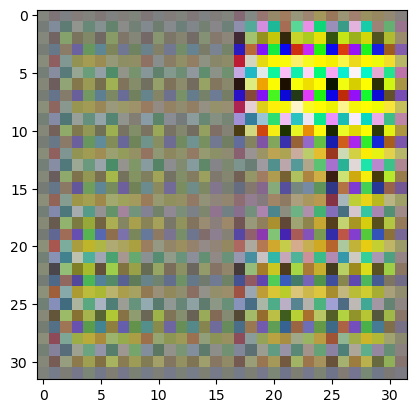

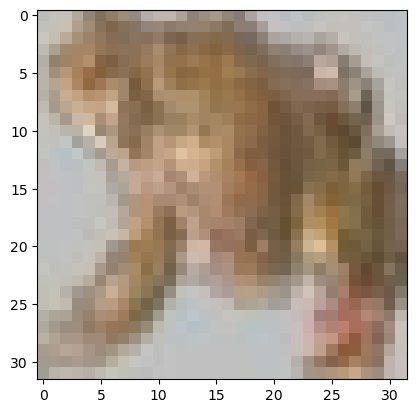

Epoch no. :  6
Discriminator loss after 0 steps = 0.46446458250284195
Discriminator loss after 0 steps = 0.46505415439605713
Generator loss after 0 steps = 0.25582155585289


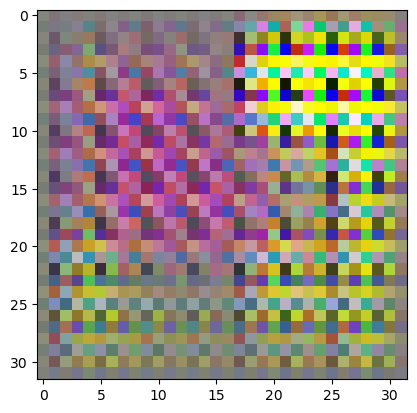

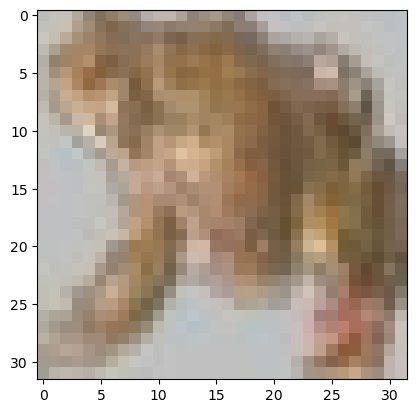

Epoch no. :  7
Discriminator loss after 0 steps = 0.46505415439605713
Discriminator loss after 0 steps = 0.4630041643977165
Generator loss after 0 steps = 0.2466123104095459


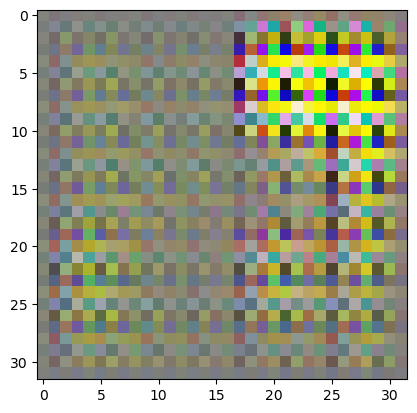

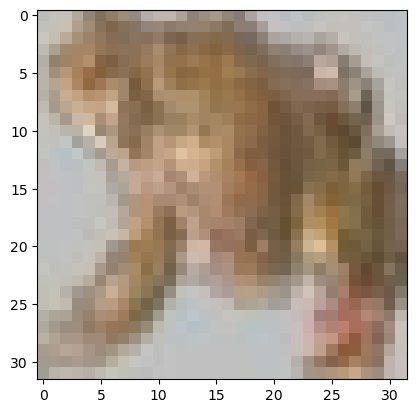

Epoch no. :  8
Discriminator loss after 0 steps = 0.4630041643977165
Discriminator loss after 0 steps = 0.46220824122428894
Generator loss after 0 steps = 0.24764633178710938


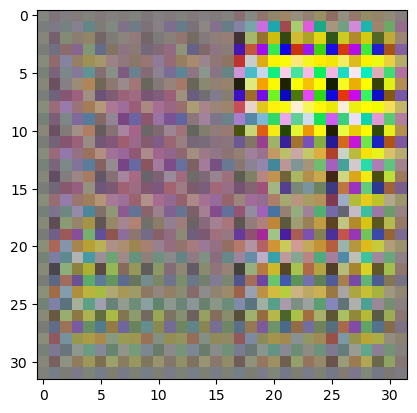

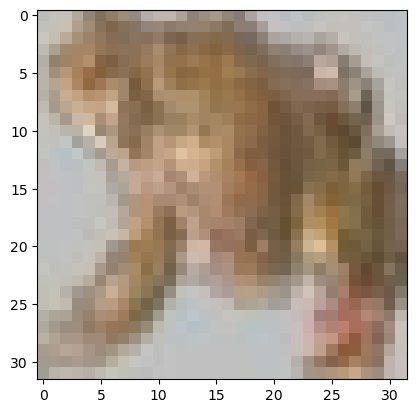

Epoch no. :  9
Discriminator loss after 0 steps = 0.46220824122428894
Discriminator loss after 0 steps = 0.463260218501091
Generator loss after 0 steps = 0.2313874065876007


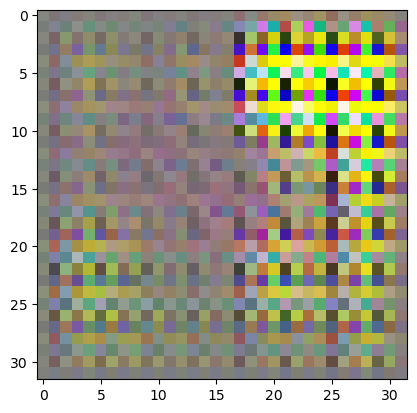

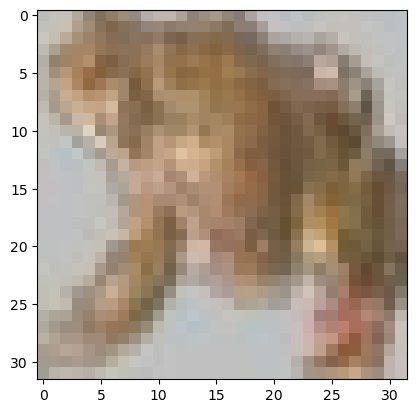

Epoch no. :  10
Discriminator loss after 0 steps = 0.463260218501091
Discriminator loss after 0 steps = 0.47906458377838135
Generator loss after 0 steps = 0.23642775416374207


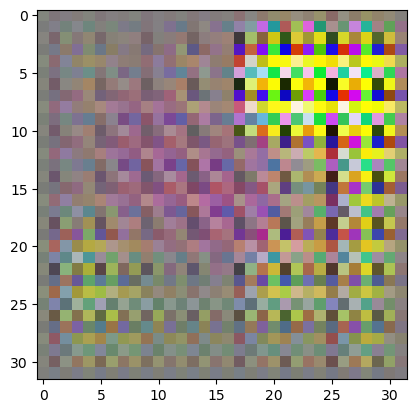

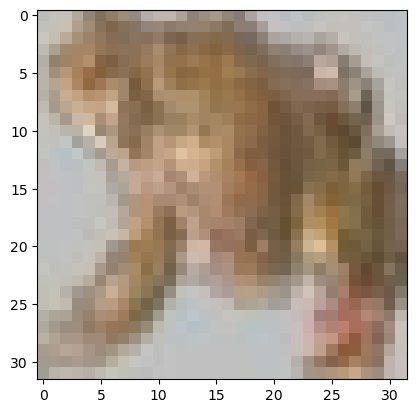

Epoch no. :  11
Discriminator loss after 0 steps = 0.47906458377838135
Discriminator loss after 0 steps = 0.46793244034051895
Generator loss after 0 steps = 0.2472059726715088


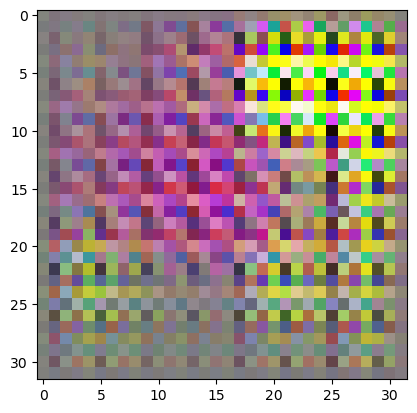

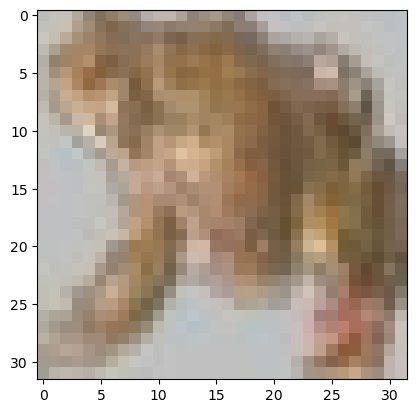

Epoch no. :  12
Discriminator loss after 0 steps = 0.46793244034051895
Discriminator loss after 0 steps = 0.4619181901216507
Generator loss after 0 steps = 0.2861133813858032


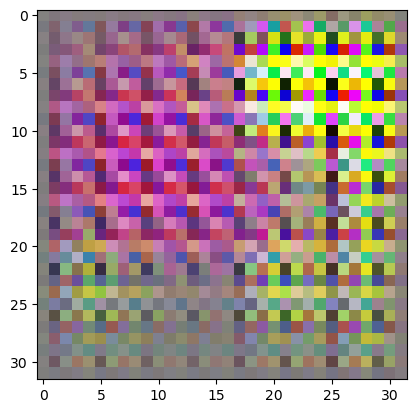

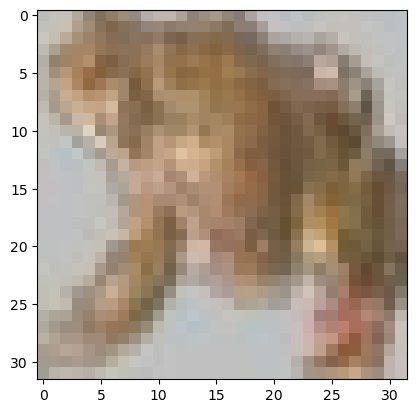

Epoch no. :  13
Discriminator loss after 0 steps = 0.4619181901216507
Discriminator loss after 0 steps = 0.46237874776124954
Generator loss after 0 steps = 0.23960243165493011


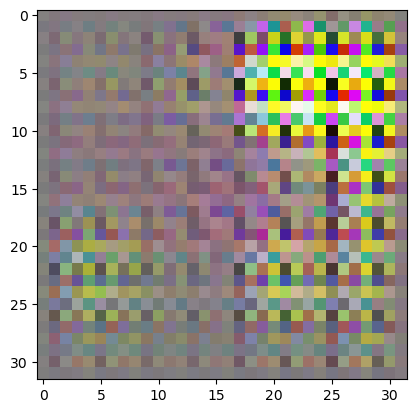

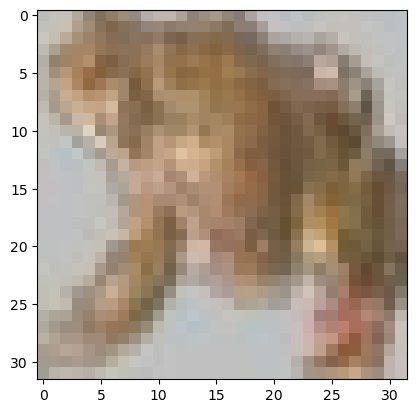

Epoch no. :  14
Discriminator loss after 0 steps = 0.46237874776124954
Discriminator loss after 0 steps = 0.4611780196428299
Generator loss after 0 steps = 0.2252485603094101


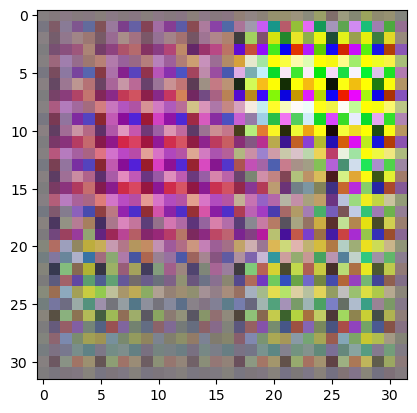

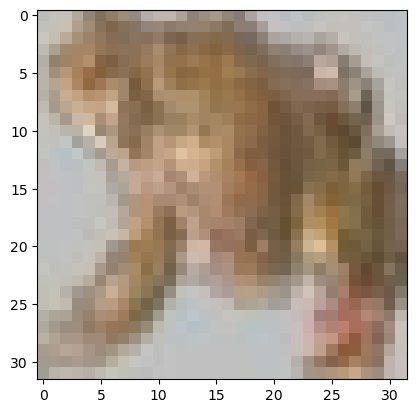

Epoch no. :  15
Discriminator loss after 0 steps = 0.4611780196428299
Discriminator loss after 0 steps = 0.4728189706802368
Generator loss after 0 steps = 0.21315696835517883


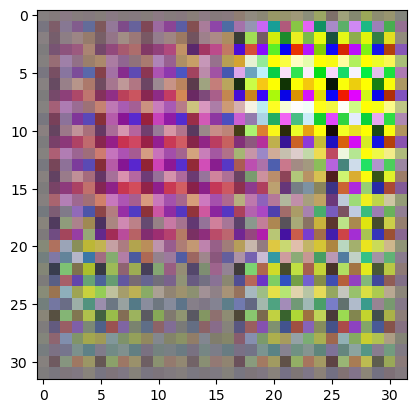

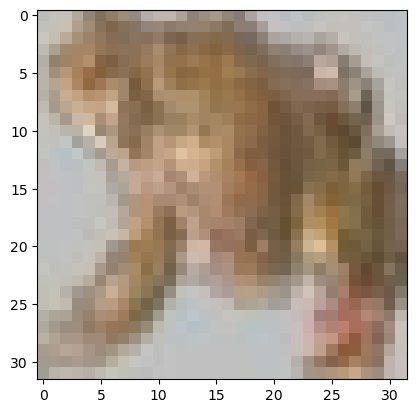

Epoch no. :  16
Discriminator loss after 0 steps = 0.4728189706802368
Discriminator loss after 0 steps = 0.461947426199913
Generator loss after 0 steps = 0.20633524656295776


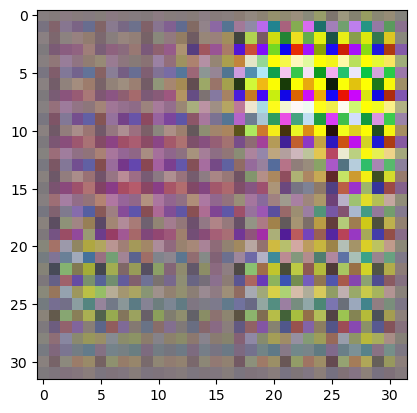

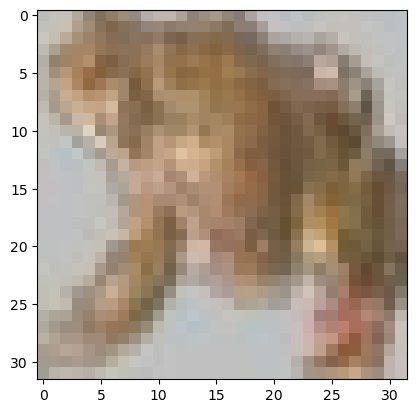

Epoch no. :  17
Discriminator loss after 0 steps = 0.461947426199913
Discriminator loss after 0 steps = 0.46223273128271103
Generator loss after 0 steps = 0.2311846911907196


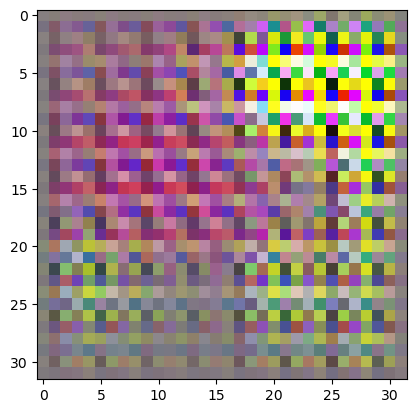

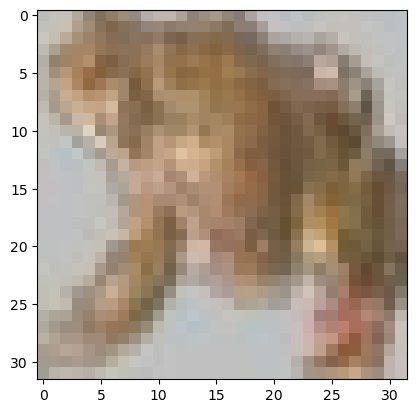

Epoch no. :  18
Discriminator loss after 0 steps = 0.46223273128271103
Discriminator loss after 0 steps = 0.46047254651784897
Generator loss after 0 steps = 0.25188586115837097


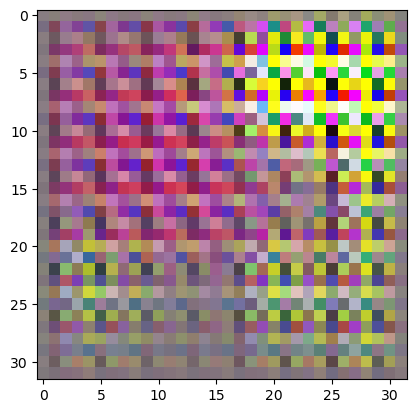

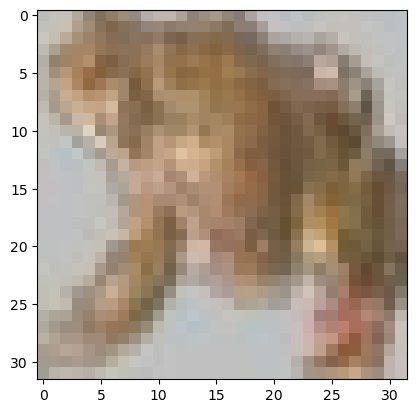

Epoch no. :  19
Discriminator loss after 0 steps = 0.46047254651784897
Discriminator loss after 0 steps = 0.46068814396858215
Generator loss after 0 steps = 0.21386650204658508


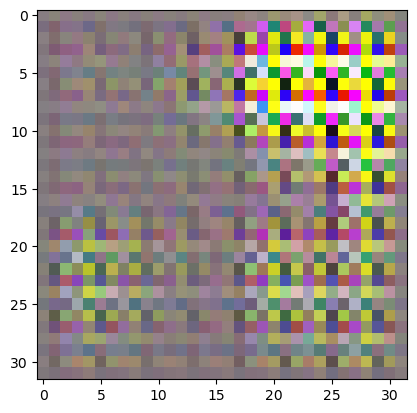

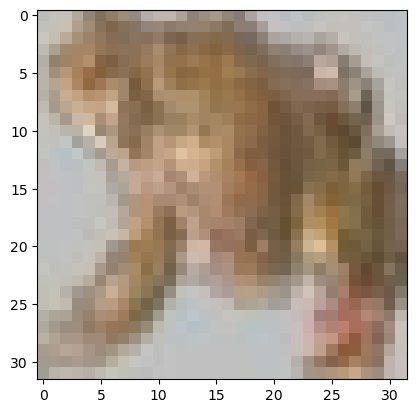

Epoch no. :  20
Discriminator loss after 0 steps = 0.46068814396858215
Discriminator loss after 0 steps = 0.4584958553314209
Generator loss after 0 steps = 0.23805390298366547


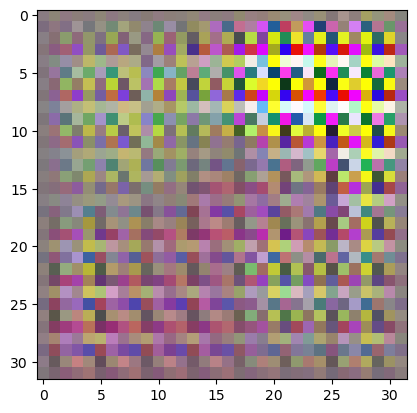

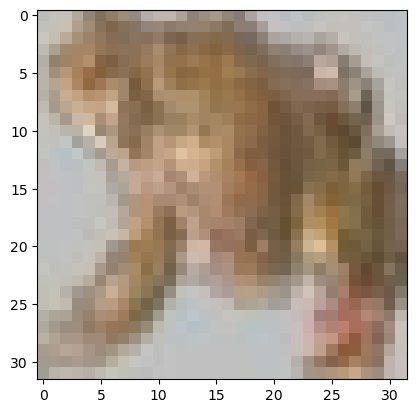

Epoch no. :  21
Discriminator loss after 0 steps = 0.4584958553314209
Discriminator loss after 0 steps = 0.45986664295196533
Generator loss after 0 steps = 0.48921823501586914


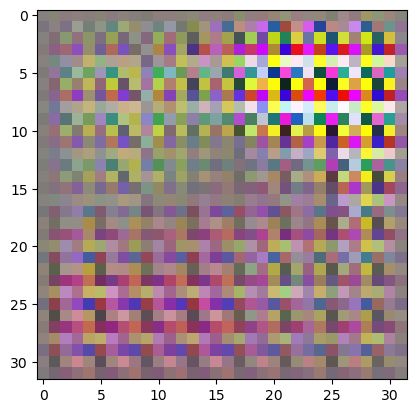

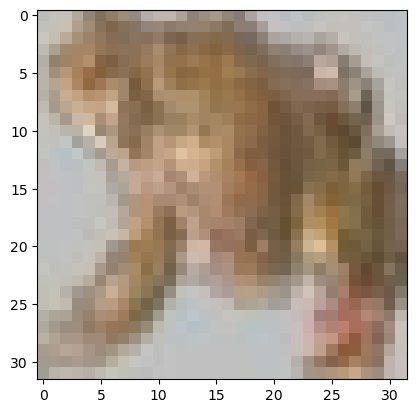

Epoch no. :  22
Discriminator loss after 0 steps = 0.45986664295196533
Discriminator loss after 0 steps = 0.4609040170907974
Generator loss after 0 steps = 0.4853523075580597


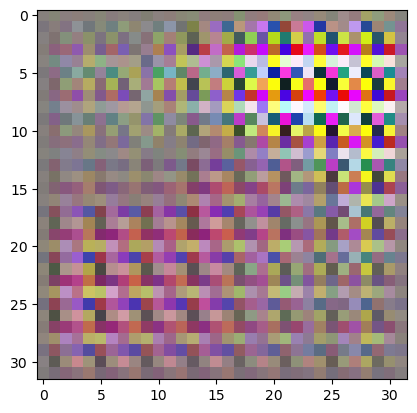

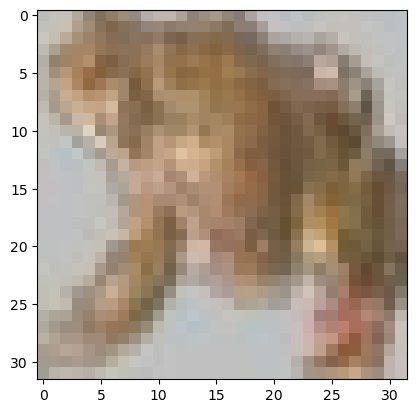

Epoch no. :  23
Discriminator loss after 0 steps = 0.4609040170907974
Discriminator loss after 0 steps = 0.459125854074955
Generator loss after 0 steps = 0.25732389092445374


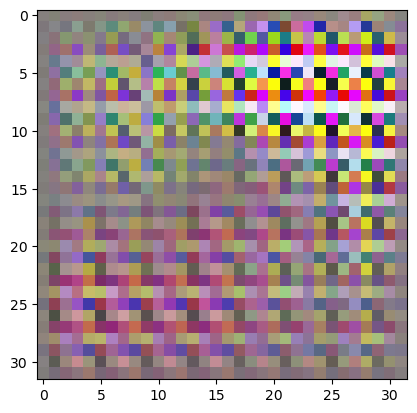

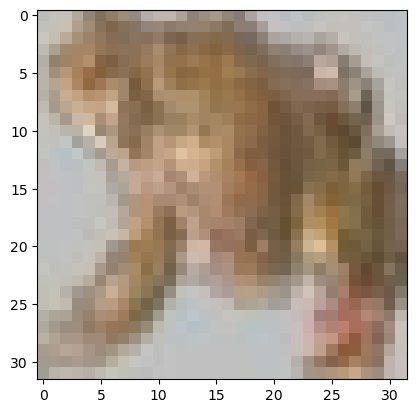

Epoch no. :  24
Discriminator loss after 0 steps = 0.459125854074955
Discriminator loss after 0 steps = 0.4600774571299553
Generator loss after 0 steps = 0.19960719347000122


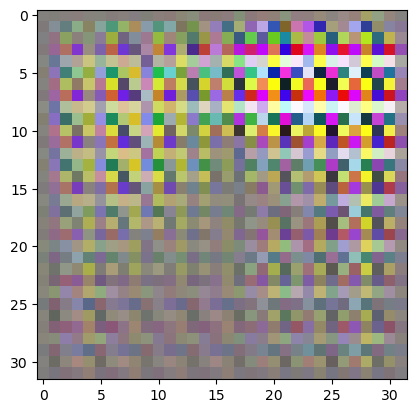

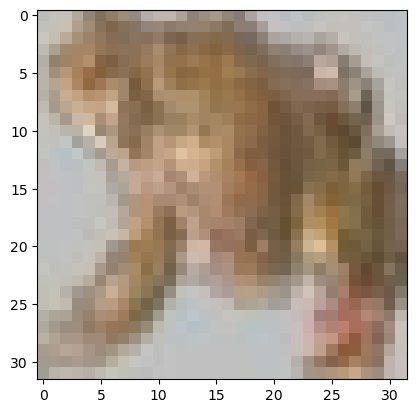

Epoch no. :  25
Discriminator loss after 0 steps = 0.4600774571299553
Discriminator loss after 0 steps = 0.45991259068250656
Generator loss after 0 steps = 0.19890578091144562


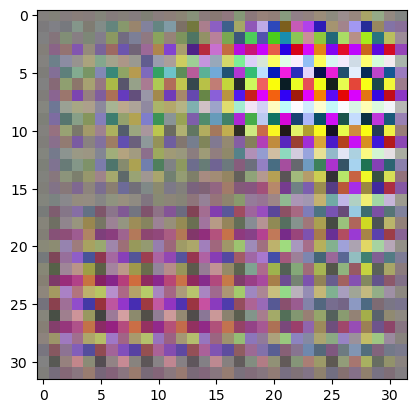

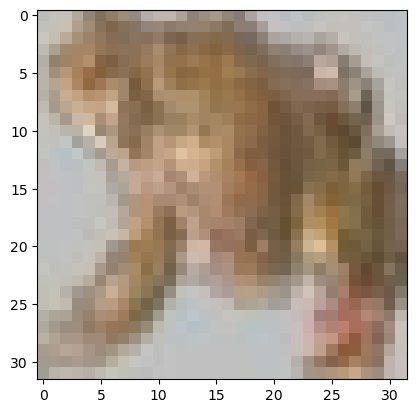

Epoch no. :  26
Discriminator loss after 0 steps = 0.45991259068250656
Discriminator loss after 0 steps = 0.46905530244112015
Generator loss after 0 steps = 0.2349134385585785


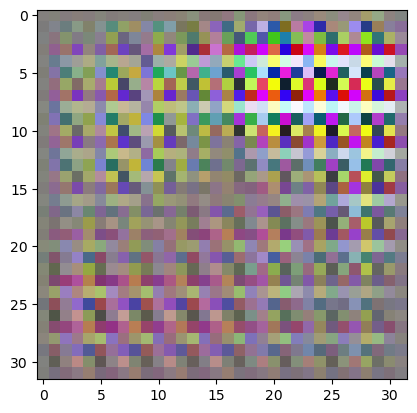

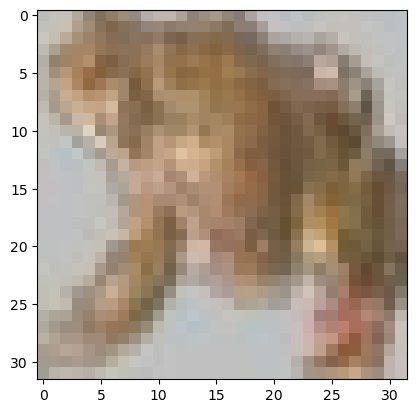

Epoch no. :  27
Discriminator loss after 0 steps = 0.46905530244112015
Discriminator loss after 0 steps = 0.4593214839696884
Generator loss after 0 steps = 0.2125462293624878


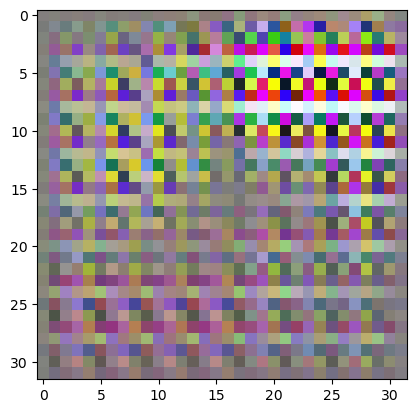

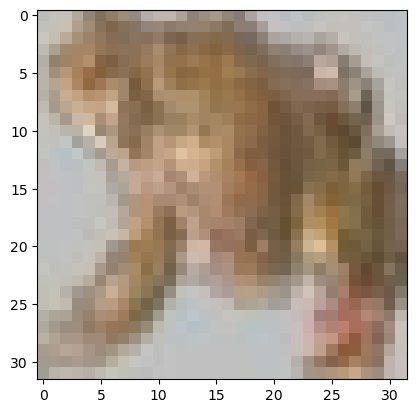

Epoch no. :  28
Discriminator loss after 0 steps = 0.4593214839696884
Discriminator loss after 0 steps = 0.4561617746949196
Generator loss after 0 steps = 0.25973445177078247


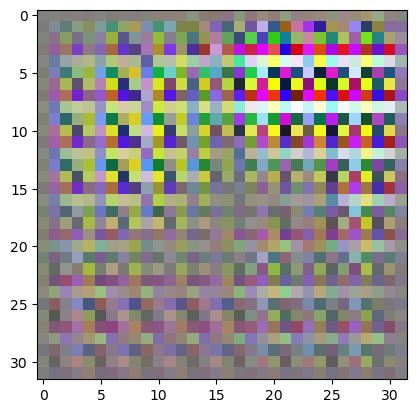

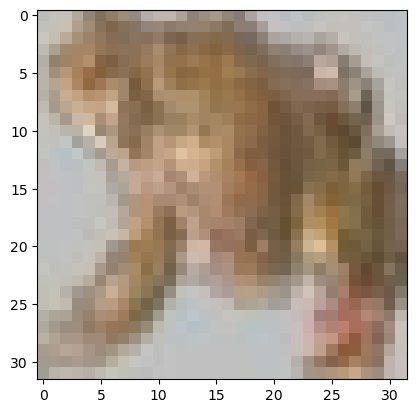

Epoch no. :  29
Discriminator loss after 0 steps = 0.4561617746949196
Discriminator loss after 0 steps = 0.6297946274280548
Generator loss after 0 steps = 0.16866084933280945


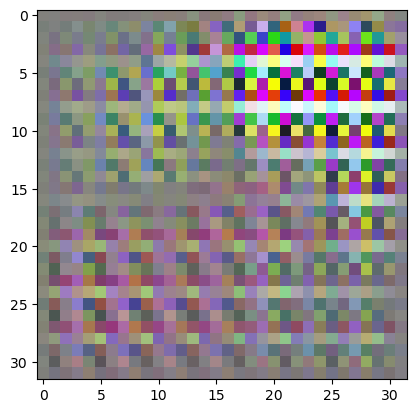

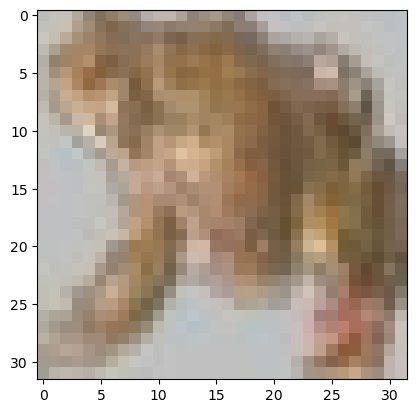

Epoch no. :  30
Discriminator loss after 0 steps = 0.6297946274280548
Discriminator loss after 0 steps = 0.4542781785130501
Generator loss after 0 steps = 0.20094718039035797


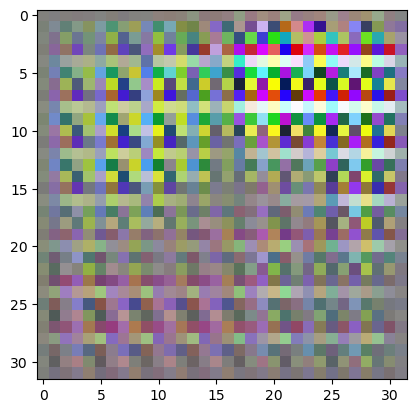

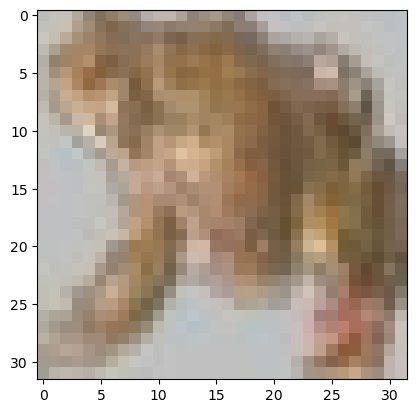

Epoch no. :  31
Discriminator loss after 0 steps = 0.4542781785130501
Discriminator loss after 0 steps = 0.45193158090114594
Generator loss after 0 steps = 0.19027943909168243


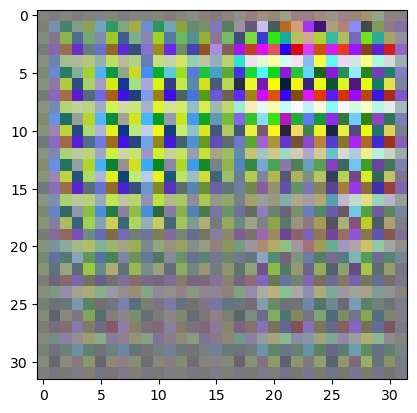

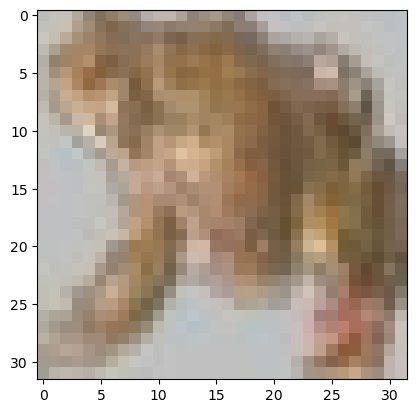

Epoch no. :  32
Discriminator loss after 0 steps = 0.45193158090114594
Discriminator loss after 0 steps = 0.5124798864126205
Generator loss after 0 steps = 0.16339577734470367


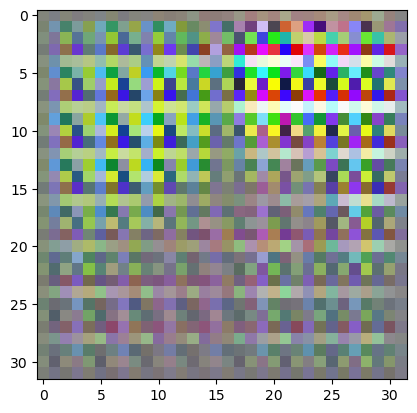

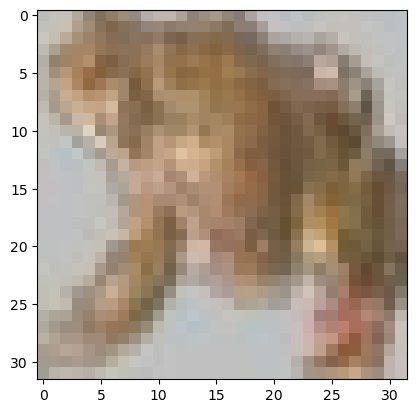

Epoch no. :  33
Discriminator loss after 0 steps = 0.5124798864126205
Discriminator loss after 0 steps = 0.445534810423851
Generator loss after 0 steps = 0.16434212028980255


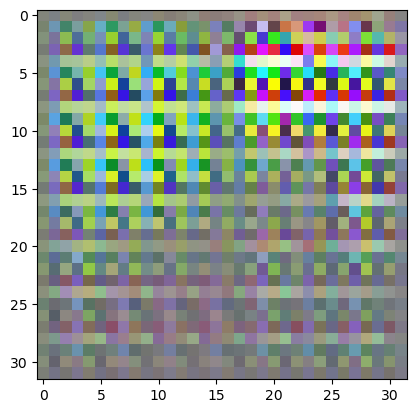

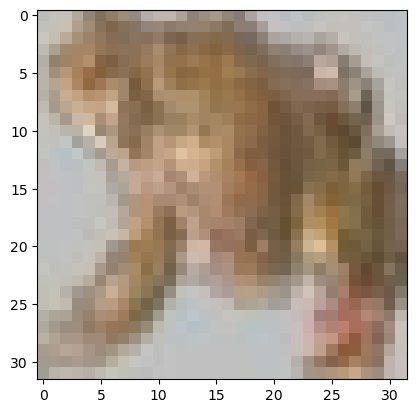

Epoch no. :  34
Discriminator loss after 0 steps = 0.445534810423851
Discriminator loss after 0 steps = 0.44224008172750473
Generator loss after 0 steps = 0.15933778882026672


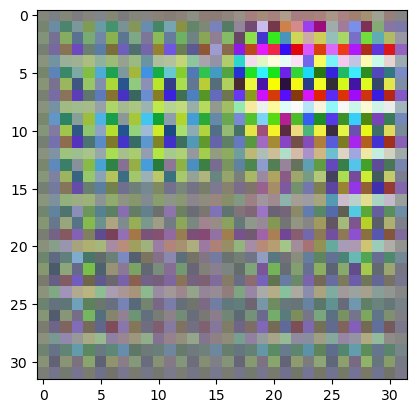

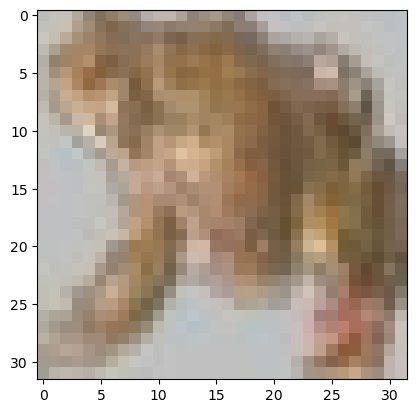

Epoch no. :  35
Discriminator loss after 0 steps = 0.44224008172750473
Discriminator loss after 0 steps = 0.4465298727154732
Generator loss after 0 steps = 0.16098050773143768


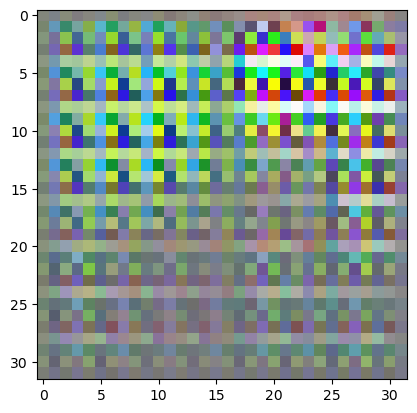

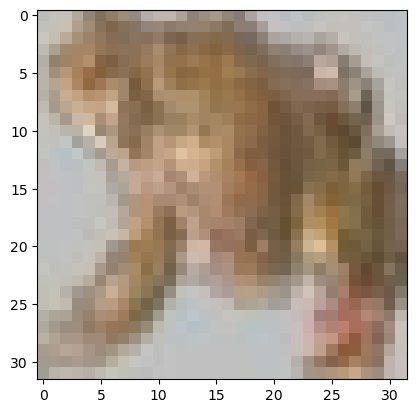

Epoch no. :  36
Discriminator loss after 0 steps = 0.4465298727154732
Discriminator loss after 0 steps = 0.44457919150590897
Generator loss after 0 steps = 0.16551829874515533


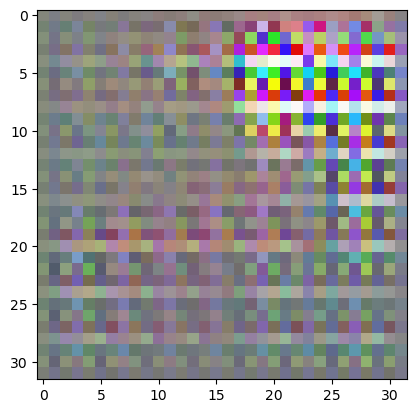

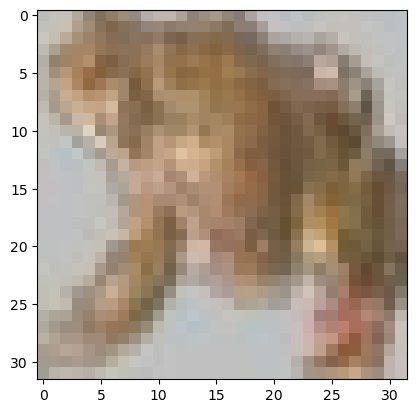

Epoch no. :  37
Discriminator loss after 0 steps = 0.44457919150590897
Discriminator loss after 0 steps = 0.43840889632701874
Generator loss after 0 steps = 0.21445971727371216


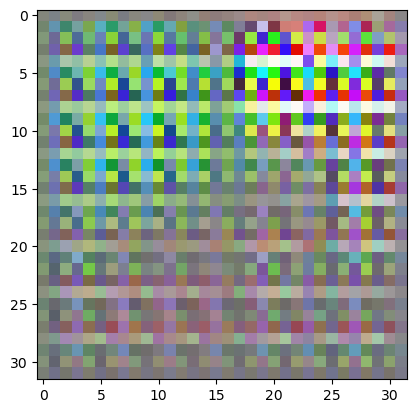

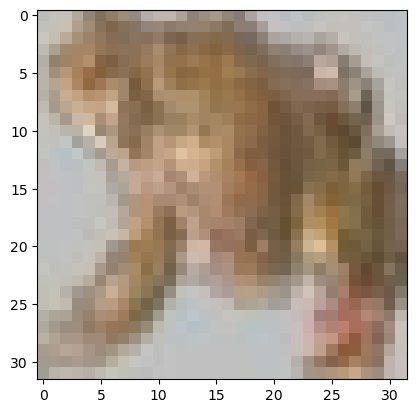

Epoch no. :  38
Discriminator loss after 0 steps = 0.43840889632701874
Discriminator loss after 0 steps = 0.44314805418252945
Generator loss after 0 steps = 0.24106234312057495


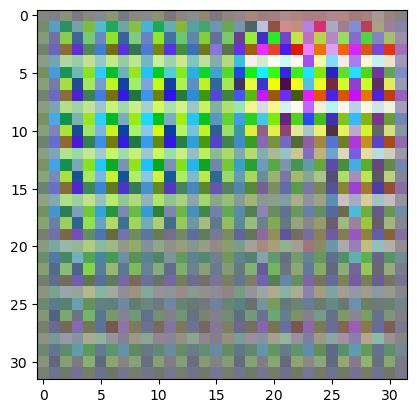

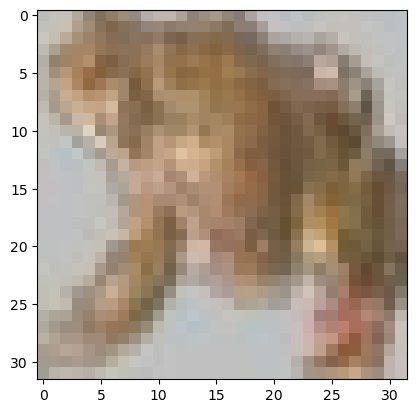

Epoch no. :  39
Discriminator loss after 0 steps = 0.44314805418252945
Discriminator loss after 0 steps = 0.4358421713113785
Generator loss after 0 steps = 0.16170096397399902


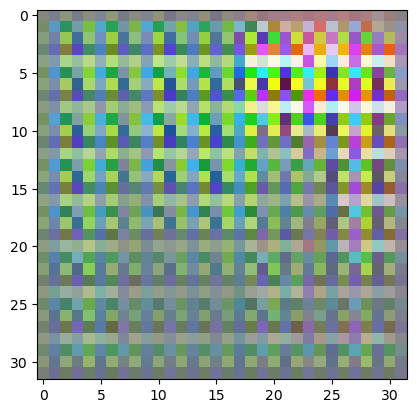

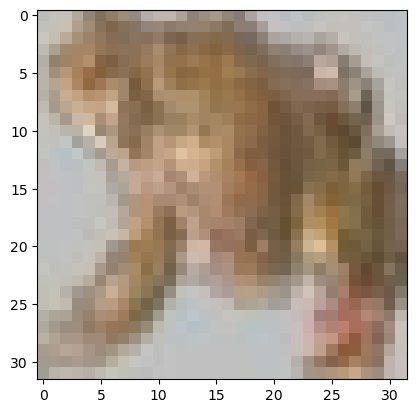

Epoch no. :  40
Discriminator loss after 0 steps = 0.4358421713113785
Discriminator loss after 0 steps = 0.5656480193138123
Generator loss after 0 steps = 0.1612509936094284


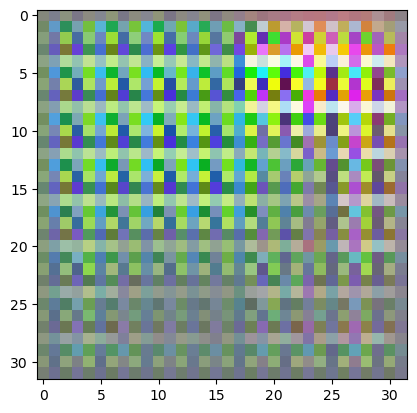

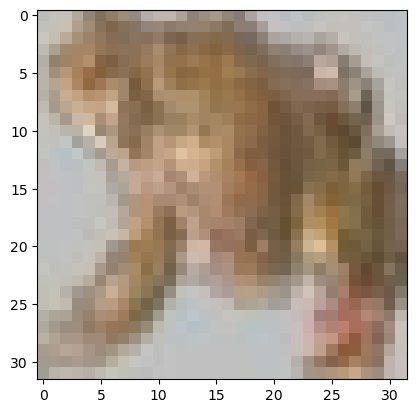

In [14]:
g_lr = 1e-4
d_lr = 4e-4
k = 2
num_epochs = 40
l_disc, l_gen, img = train(num_epochs, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=200, disc_lr=d_lr, gen_lr=g_lr, k=k)
loss_disc.append(l_disc)
loss_gen.append(l_gen)
images.append(img)

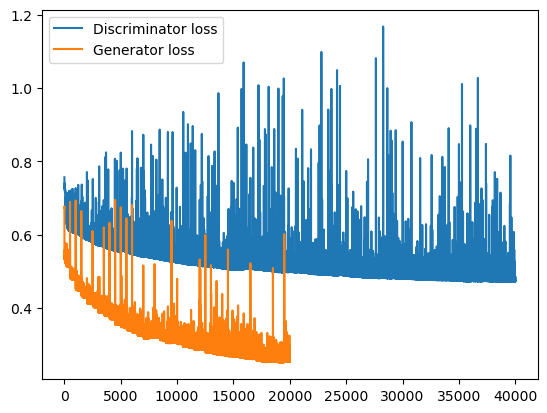

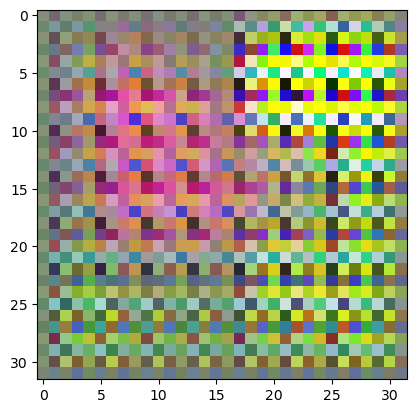

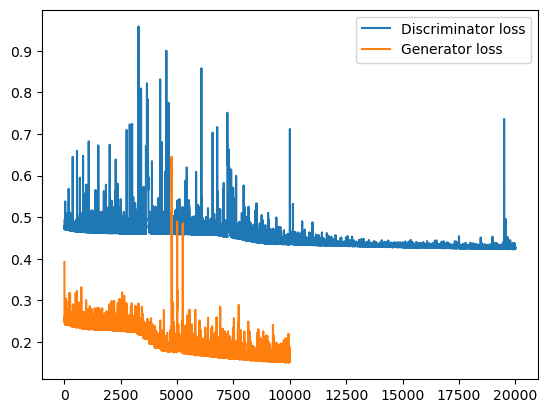

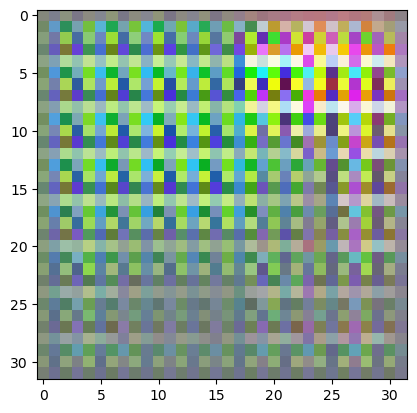

In [15]:
for i in range(len(loss_gen)):
    plt.plot(loss_disc[i])
    plt.plot(loss_gen[i])
    plt.legend(["Discriminator loss", "Generator loss"])
    plt.show()
    plt.imshow(images[i][-1])
    plt.show()
    # plt., loss_d[0]


In [16]:
with torch.no_grad():
    gen_img = gen(torch.rand(10, dim_z, 1, 1, device=device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


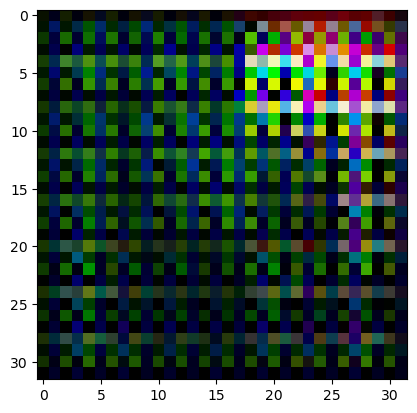

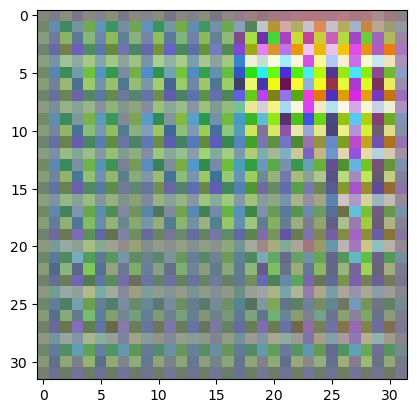

tensor([[[ 0.0379, -0.0322,  0.0833,  ...,  0.3193,  0.2357,  0.0870],
         [-0.1092, -0.2194, -0.5583,  ...,  0.4576,  0.2050,  0.1607],
         [ 0.0435, -0.1094,  0.1123,  ...,  0.2318,  0.3884,  0.2451],
         ...,
         [-0.1431, -0.2209, -0.3590,  ..., -0.1490, -0.3133, -0.0806],
         [ 0.0744, -0.2367,  0.1181,  ..., -0.1801,  0.1520, -0.0770],
         [-0.0619, -0.1332, -0.1664,  ..., -0.1027, -0.1318, -0.0540]],

        [[ 0.0704, -0.0083,  0.1335,  ...,  0.1175, -0.0278,  0.0247],
         [ 0.0766,  0.1424,  0.1051,  ...,  0.3151,  0.2317,  0.1927],
         [ 0.2265, -0.0399,  0.4872,  ..., -0.2005,  0.4473,  0.0365],
         ...,
         [ 0.0544, -0.0392,  0.1047,  ..., -0.1214,  0.1530,  0.0968],
         [ 0.1853, -0.1130,  0.3021,  ..., -0.0957,  0.3304, -0.0274],
         [-0.0014, -0.1252, -0.0260,  ..., -0.0879, -0.0459, -0.0534]],

        [[-0.0211,  0.1045, -0.0110,  ...,  0.1578, -0.0042,  0.0582],
         [-0.1723,  0.4586, -0.2546,  ...,  0

In [17]:
print(gen_img[0].shape)
plt.imshow(gen_img[1].cpu().detach().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(denormalize_images(gen_img[1].cpu().detach().numpy().transpose(1, 2, 0)))
plt.show()
print(gen_img[0])
# print(disc(gen_img).flatten())

In [ ]:
loss_fn = torch.nn.BCELoss()

train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0)
batch_size = 50
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)
if train == False:
    val_dataset = ValDataset(data_dir_val)
    val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=val_sampler,
    )

optimG = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.0))
optimD = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.0))

# for j, mini_batch in enumerate(train_loader):
mini_batch = next(iter(train_loader))
optimG.zero_grad()

for _ in range(3):
    optimD.zero_grad()

    # train disc first
    x_real = mini_batch["img"].to(device)
    x_real = x_real.view(batch_size, num_in_channels, 32, 32)
    labels = torch.full(
        (batch_size,), 1.0, dtype=torch.float32, device=device
    )
    # out_disc_r = disc(x_real).flatten().sigmoid()
    out_disc_r = disc(x_real).flatten()

    # print(out_disc_r)
    loss_disc_r = loss_fn(out_disc_r, labels)
    loss_disc_r.backward()

    x_fake = gen(torch.randn(batch_size, dim_z, 1, 1))
    labels = torch.full(
        (batch_size,), 0.0, dtype=torch.float32, device=device
    )
    # out_disc_f = disc(x_fake).flatten().sigmoid()
    out_disc_f = disc(x_fake).flatten()
    loss_disc_f = loss_fn(out_disc_f, labels)
    loss_disc_f.backward()

    loss_disc = (
        loss_disc_f.mean().item() + loss_disc_r.mean().item()
    ) / 2.0
    if _ != 2:
        optimD.step()

# train gen
x_gen = gen(torch.randn(batch_size, dim_z, 1, 1))
# out = disc(x_gen).flatten().sigmoid()
out = disc(x_gen).flatten()
labels = torch.full(
    (batch_size,), 1.0, dtype=torch.float32, device=device
)
loss_gen = loss_fn(out, labels)
loss_gen.backward()


# optimG.step()

In [ ]:
def train(gpu, args):
    rank = args.nr * args.gpus + gpu
    torch.distributed.init_process_group(
        backend="nccl",
        init_method="env://",
        world_size=args.world_size,
        rank=rank,
    )

    torch.manual_seed(0)
    torch.cuda.set_device(gpu)
    model = test_net().cuda(gpu)

    batch_size = 100

    loss_fn = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters(), lr=1e4)
    model = nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
    # model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
    # model = DDP(model)

    total_steps = len(train_loader)
    for epoch in range(args.epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)

            if (i + 1) % 100 == 0 and gpu == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, args.epochs, i + 1, total_steps, loss.item()
                    )
                )